In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from IPython.display import clear_output

Test set: Average loss: 0.1316, Accuracy: 0.9605
Test set: Average loss: 0.0959, Accuracy: 0.9705
Test set: Average loss: 0.0769, Accuracy: 0.9771
Test set: Average loss: 0.0819, Accuracy: 0.9758
Test set: Average loss: 0.0731, Accuracy: 0.9779
Test set: Average loss: 0.0792, Accuracy: 0.9764
Test set: Average loss: 0.0680, Accuracy: 0.9801
Test set: Average loss: 0.0651, Accuracy: 0.9816
Test set: Average loss: 0.0657, Accuracy: 0.9821
Test set: Average loss: 0.0682, Accuracy: 0.9820
Test set: Average loss: 0.0663, Accuracy: 0.9828
Test set: Average loss: 0.0659, Accuracy: 0.9829
Test set: Average loss: 0.0658, Accuracy: 0.9835
Test set: Average loss: 0.0663, Accuracy: 0.9832
Test set: Average loss: 0.0664, Accuracy: 0.9835
Test set: Average loss: 0.0667, Accuracy: 0.9837
Test set: Average loss: 0.0671, Accuracy: 0.9840
Test set: Average loss: 0.0674, Accuracy: 0.9837
Test set: Average loss: 0.0678, Accuracy: 0.9839
Test set: Average loss: 0.0678, Accuracy: 0.9841
Test set: Average lo

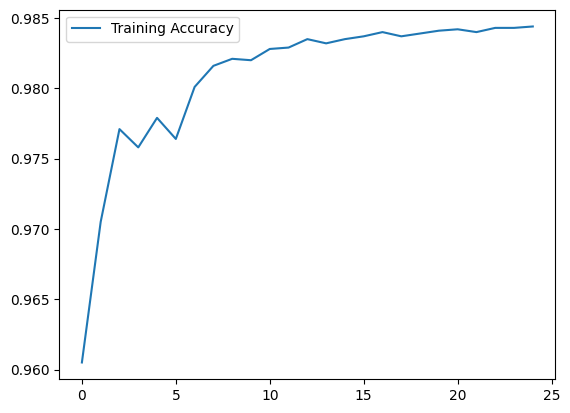

In [5]:
# Define the number of clients and the batch size for each client
num_clients = 25
batch_size = 1

# Load the training and testing data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split the training data into num_clients number of subsets
train_data_split = torch.utils.data.random_split(train_data, [len(train_data)//num_clients]*num_clients)

# Define the model architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784, 256)
        self.fc2 = torch.nn.Linear(256, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

# Train the model on each client's subset of the data
def train_client(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

# Evaluate the model on the test data
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    return test_loss, correct/len(test_loader.dataset)

# Initialize the model and the optimizer
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model on each client's subset of the data
train_loss = []
train_acc = []
for epoch in range(25):
    for i in range(num_clients):
        train_loader = DataLoader(train_data_split[i], batch_size=batch_size, shuffle=True)
        train_client(model, 'cpu', train_loader, optimizer, epoch)

    # Evaluate the model on the test data after each epoch
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    test_loss, test_acc = test(model, 'cpu', test_loader)
    train_loss.append(test_loss)
    train_acc.append(test_acc)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

# Plot the training and testing accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.legend()
plt.show()


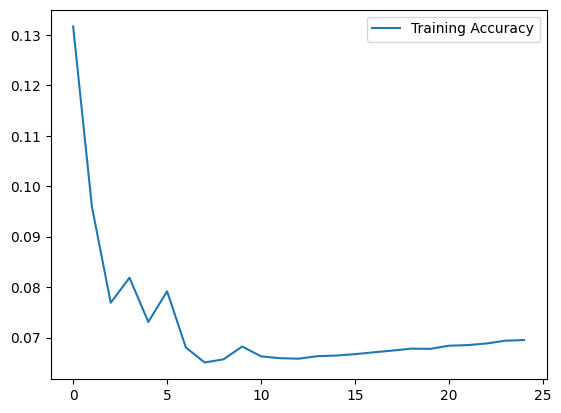

In [6]:
# Plot the training and testing accuracy
plt.plot(train_loss,label='Training Accuracy')
plt.legend()
plt.show()


In [7]:
import torch
import copy
import numpy as np

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from copy import deepcopy

# Define the client device class
class Client:
    def __init__(self, data, target, model):
        self.data = torch.tensor(data).float().to(device)
        self.target = torch.tensor(target).long().to(device)
        self.model = deepcopy(model)

    def train(self):
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.1)
        criterion = torch.nn.CrossEntropyLoss()

        optimizer.zero_grad()
        output = self.model(self.data)
        loss = criterion(output, self.target)
        loss.backward()
        optimizer.step()

        return deepcopy(self.model.state_dict())

# Define the server device class
class Server:
    def __init__(self, model):
        self.model = model

    def aggregate(self, weights):
        new_state = {}
        for key in self.model.state_dict():
            new_state[key] = torch.mean(torch.stack([weights[i][key].float() for i in range(len(weights))]), dim=0)
        self.model.load_state_dict(new_state)

    def test(self, data, target):
        self.model.eval()
        data = torch.tensor(data).float().to(device)
        target = torch.tensor(target).long().to(device)
        output = self.model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / len(data)
        return accuracy

# Define the function for filtering out byzantine clients
def byzantine_elimination(weights):
    median = np.median([list(weights[i].values()) for i in range(len(weights))], axis=0)
    deviations = [np.abs(np.array(list(weights[i].values())) - median) for i in range(len(weights))]
    threshold = np.median(deviations)
    good_idxs = [i for i in range(len(deviations)) if np.all(deviations[i] <= threshold)]
    filtered_weights = [weights[i] for i in good_idxs]
    return filtered_weights

# Generate some dummy data for the clients
num_clients = 25
data = np.random.rand(num_clients, 1, 28, 28)
target = np.random.randint(0, 10, size=(num_clients,))

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the client and server devices and train the model with federated learning
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(32, 64, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 2 * 2, 25)  # Adjust the input size as needed
).to(device)


clients = [Client(data[i], target[i], model) for i in range(num_clients)]
server = Server(model)

num_rounds = 10
for i in range(num_rounds):
    print(f"Round {i+1}")
    weights = [client.train() for client in clients]
    filtered_weights = byzantine_elimination(weights)
    server.aggregate(filtered_weights)

    # Test the model on some holdout data
    test_data = np.random.rand(100, 1, 28, 28)
    test_target = np.random.randint(0, 10, size=(100,))
    accuracy = server.test(test_data, test_target)
    print(f"Test Accuracy: {accuracy:.4f}")


Round 1


RuntimeError: ignored

In [9]:
# # Define the client device class
# class Client:
#     def __init__(self, data, target, model):
#         self.data = torch.tensor(data).float()
#         self.target = torch.tensor(target).long()
#         self.model = copy.deepcopy(model)

#     def train(self):
#         self.model.train()
#         optimizer = torch.optim.SGD(self.model.parameters(), lr=0.1)
#         criterion = torch.nn.CrossEntropyLoss()

#         optimizer.zero_grad()
#         output = self.model(self.data)
#         loss = criterion(output, self.target)
#         loss.backward()
#         optimizer.step()

#         return copy.deepcopy(self.model.state_dict())

# # Define the server device class
# class Server:
#     def __init__(self, model):
#         self.model = model

#     def aggregate(self, weights):
#         new_state = {}
#         for key in self.model.state_dict():
#             new_state[key] = torch.mean(torch.stack([weights[i][key].float() for i in range(len(weights))]), dim=0)
#         self.model.load_state_dict(new_state)

#     def test(self, data, target):
#         self.model.eval()
#         data = torch.tensor(data).float()
#         target = torch.tensor(target).long()
#         output = self.model(data)
#         pred = output.argmax(dim=1, keepdim=True)
#         correct = pred.eq(target.view_as(pred)).sum().item()
#         accuracy = correct / len(data)
#         return accuracy

# # Define the function for filtering out byzantine clients
# def byzantine_elimination(weights):
#     median = np.median([weights[i].values() for i in range(len(weights))], axis=0)
#     deviations = [np.abs(np.array(list(weights[i].values())) - median) for i in range(len(weights))]
#     threshold = np.median(deviations)
#     good_idxs = [i for i in range(len(deviations)) if deviations[i] <= threshold]
#     filtered_weights = [weights[i] for i in good_idxs]
#     return filtered_weights

# # Generate some dummy data for the clients
# num_clients = 25
# data = np.random.rand(num_clients, 1, 28, 28)
# target = np.random.randint(0, 10, size=(num_clients,))

# # Create the client and server devices and train the model with federated learning
# # model = torch.nn.Sequential(
# #     torch.nn.Conv2d(1, 32, kernel_size=3),
# #     torch.nn.ReLU(),
# #     torch.nn.MaxPool2d(kernel_size=2),
# #     torch.nn.Conv2d(32, 64, kernel_size=3),
# #     torch.nn.ReLU(),
# #     torch.nn.MaxPool2d(kernel_size=2),
# #     torch.nn.Flatten(),
# #     torch.nn.Linear(64 * 5 * 5, 10)
# # )

# model = torch.nn.Sequential(
#     torch.nn.Conv2d(1, 32, kernel_size=3),
#     torch.nn.ReLU(),
#     torch.nn.MaxPool2d(kernel_size=2),
#     torch.nn.Conv2d(32, 64, kernel_size=3),
#     torch.nn.ReLU(),
#     torch.nn.MaxPool2d(kernel_size=2),
#     torch.nn.Flatten(),
#     torch.nn.Linear(64 * 5 * 5, 10)  # Adjust the input size as needed
# )

# clients = [Client(data[i], target[i], model) for i in range(num_clients)]
# server = Server(model)

# num_rounds = 10
# for i in range(num_rounds):
#     print(f"Round {i+1}")
#     weights = [client.train() for client in clients]
#     filtered_weights = byzantine_elimination(weights)
#     server.aggregate(filtered_weights)

#     # Test the model on some holdout data
#     test_data = np.random.rand(100, 1, 28, 28)
#     test_target = np.random


Round 1


RuntimeError: ignored